In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import os

In [2]:
DATA_DIR = "/scratch_dgxl/rp1818/HM4/data" # Directory path to the data folder.

In [3]:
cm = np.load(os.path.join(DATA_DIR, "HM4_test_set_confusion_matrix.npy"))

In [4]:
labels = ['CO2 Ice', 'H2O Ice', 'Gypsum', 'Ferric Hydroxysulfate', 'Hematite', 'Nontronite', 'Saponite', 'Prehnite', 'Jarosite', 'Serpentine', 'Alunite', 'Akaganeite', 'Ca/Fe CO3', 'Beidellite', 'Kaolinite', 'Bassanite', 'Epidote', 'Montmorillonite', 'Rosenite', 'Mg Cl salt', 'Halloysite', 'Illite/Muscovite', 'Margarite', 'Analcime', 'Monohydrated sulfate', 'Opal 1', 'Opal 2', 'Iron Oxide Silicate Sulfate', 'MgCO3', 'Chlorite', 'Clinochlore', 'Low Ca Pyroxene', 'Olivine Forsterite', 'High Ca Pyroxene', 'Olivine Fayalite', 'Chloride', 'Artefact']

In [5]:
def axis_swap(map, labs, i, j):
    map[[i, j]] = map[[j, i]]
    map[:, [i, j]] = map[:, [j, i]]
    labs[i], labs[j] = labs[j], labs[i]
    return map, labs

# make a deep copy of the cm and labels
new_cm = np.empty_like(cm)
new_labels = labels.copy()
new_cm[:] = cm

# align pyroxenes
new_cm, new_labels = axis_swap(new_cm, new_labels, 32, 33)

# align carbonates
new_cm, new_labels = axis_swap(new_cm, new_labels, 11, 28)

# align Ca/Fe carb and chlorite
new_cm, new_labels = axis_swap(new_cm, new_labels, 10, 29)
new_cm, new_labels = axis_swap(new_cm, new_labels, 11, 12)

# align Chloride and LCP
new_cm, new_labels = axis_swap(new_cm, new_labels, 30, 35)

# align alunite and halloysite
new_cm, new_labels = axis_swap(new_cm, new_labels, 23, 29)
new_cm, new_labels = axis_swap(new_cm, new_labels, 21, 23)

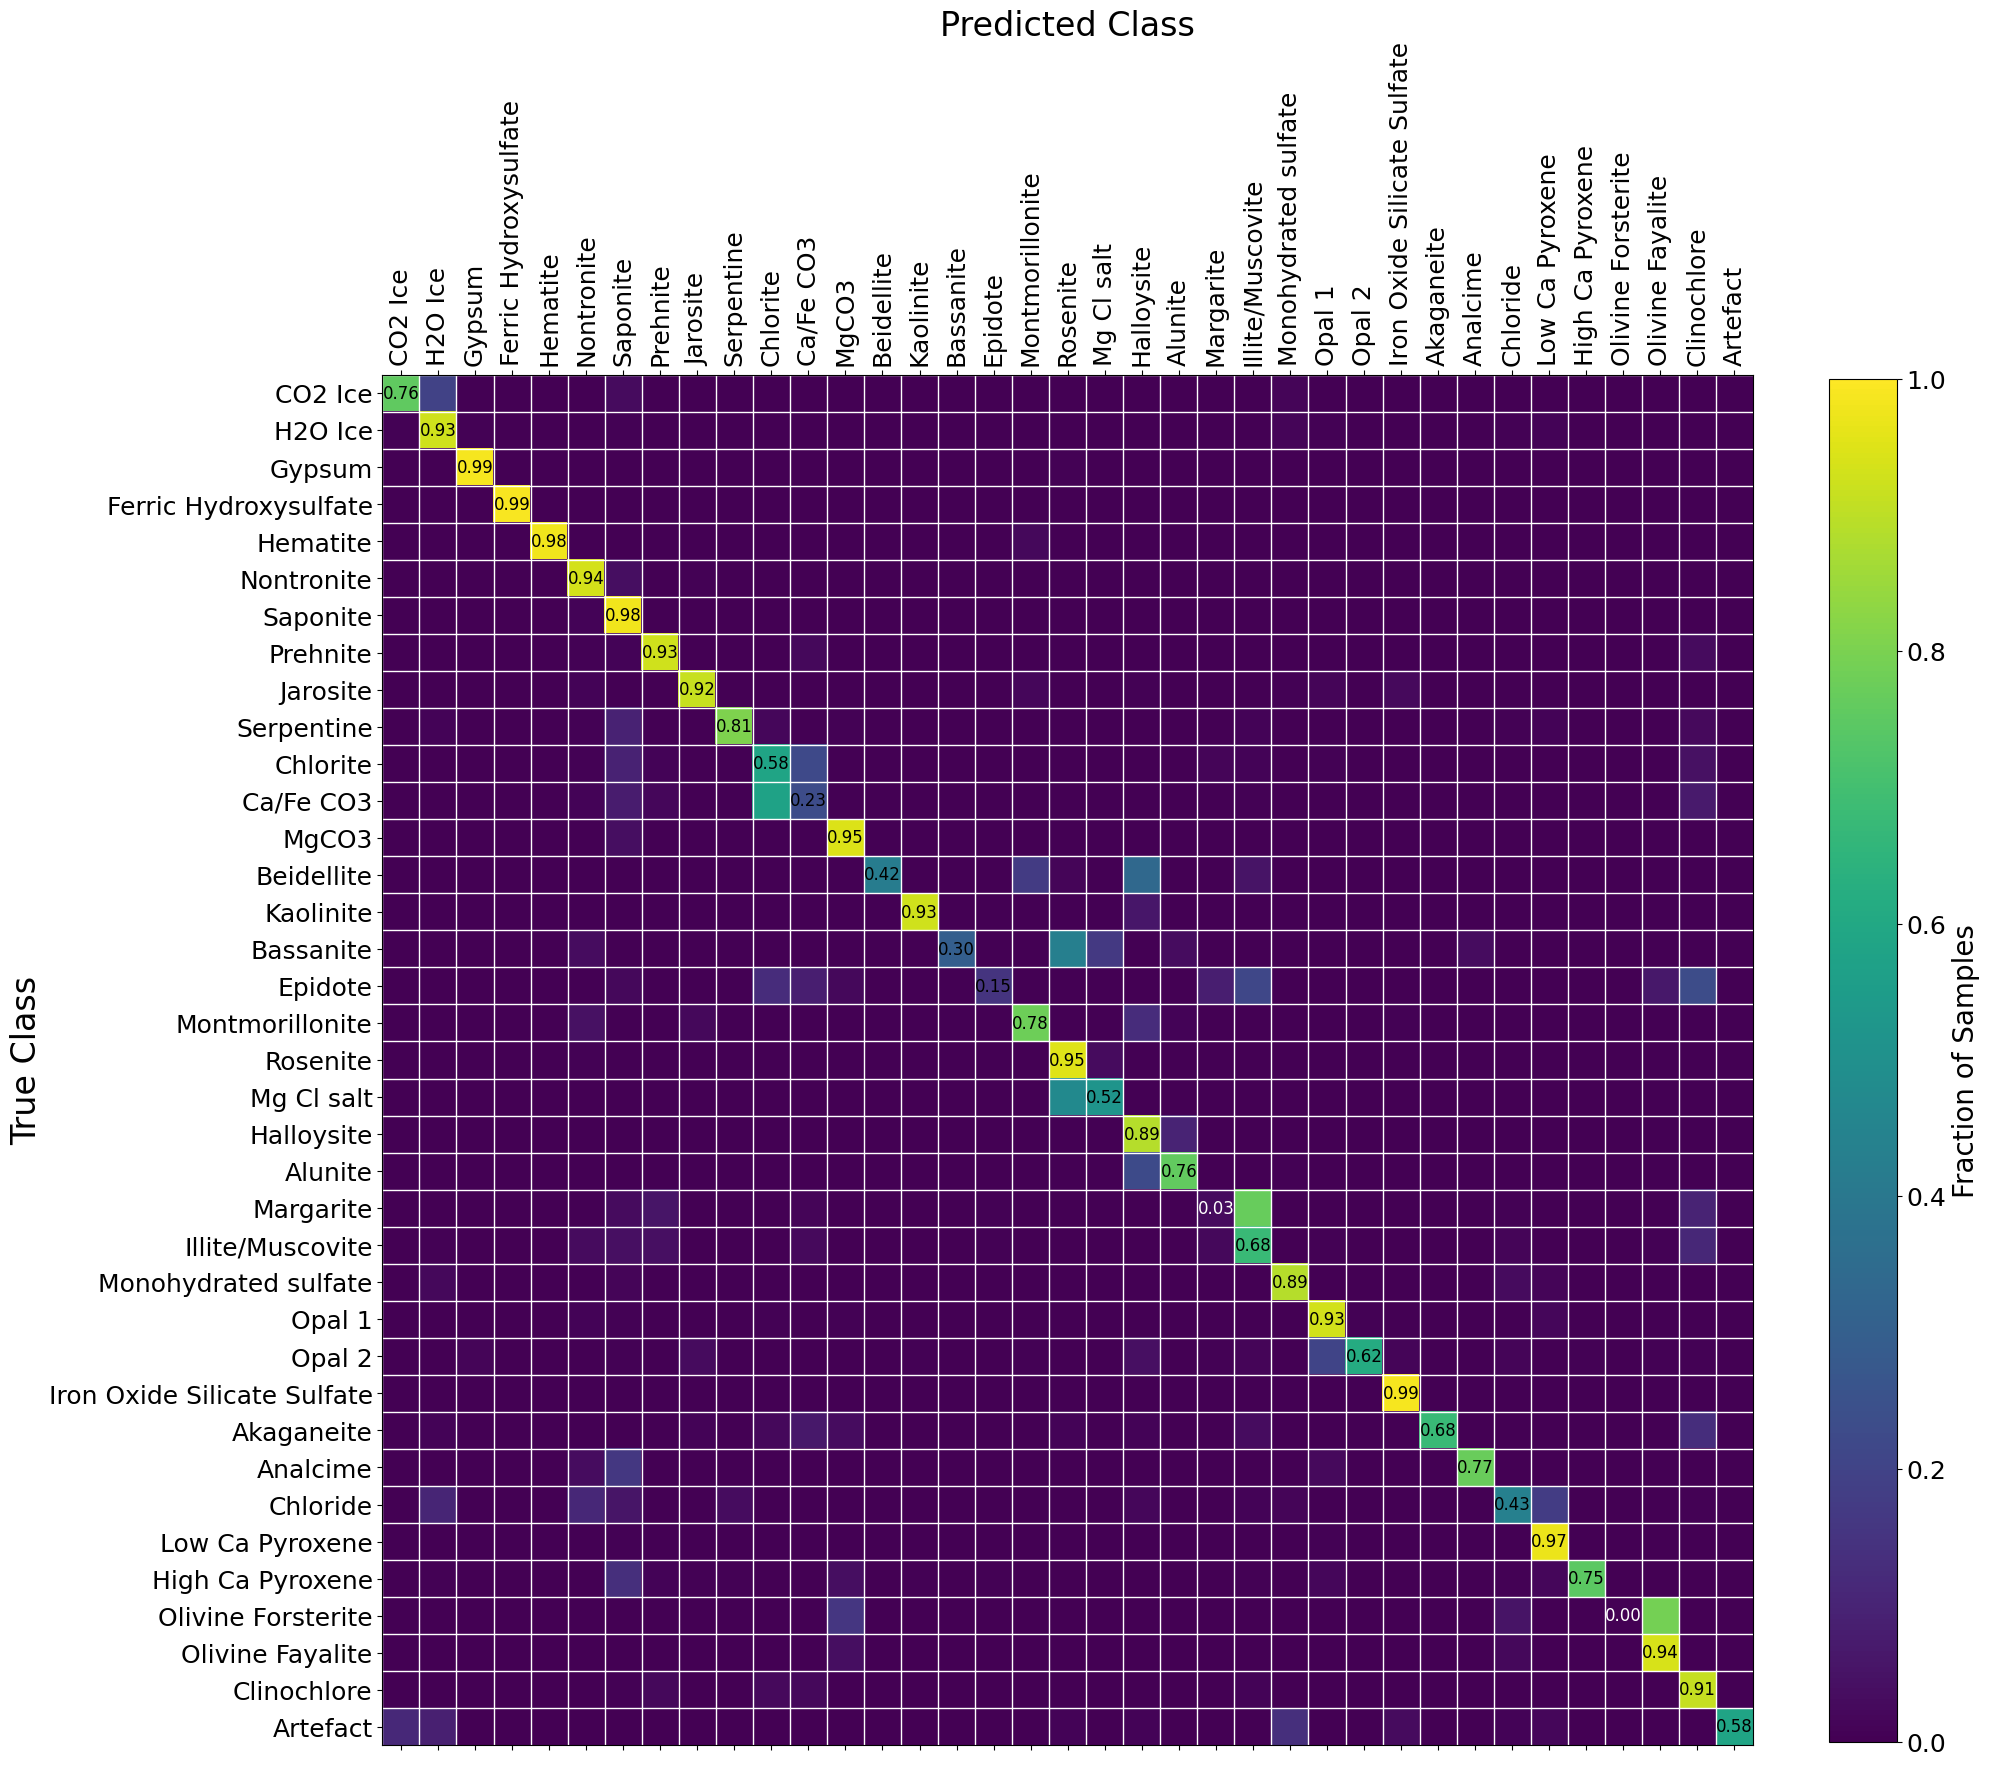

In [6]:
# take values from class_labels dict to list
fig, ax = plt.subplots(figsize=(20, 20))
ax.matshow(new_cm, cmap='viridis')
# plot the cm values in the boxes, rounded to 2dp
for i in range(len(new_labels)):
    for j in range(len(new_labels)):
        if i != j:
            continue
        if new_labels[i] == "Olivine Forsterite" or new_labels[i] == "Margarite":
            ax.text(j, i, f"{new_cm[i, j]:.2f}", ha='center', va='center', color='white', fontsize=12)
        else:
            ax.text(j, i, f"{new_cm[i, j]:.2f}", ha='center', va='center', color='black', fontsize=12)

cbar = fig.colorbar(mappable=ax.matshow(new_cm, cmap='viridis', vmin=0, vmax=1), fraction=0.045)
# make colorbar text larger
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel("Fraction of Samples", fontsize=20)
# add class labels to x and y axes
ax.set_xticks(range(len(new_labels)))
ax.set_yticks(range(len(new_labels)))
ax.set_xticklabels(new_labels, rotation=90, fontsize=18)
ax.set_yticklabels(new_labels, fontsize=18)
ax.set_ylabel("True Class", fontsize=24)
ax.set_xlabel("Predicted Class", fontsize=24)
ax.xaxis.set_label_position('top')
# add guidelines between the squares
for i in range(len(new_labels)):
    ax.axhline(i-0.5, color='white', linewidth=1)
    ax.axvline(i-0.5, color='white', linewidth=1)
plt.tight_layout()

# plt.savefig("confusion_matrix.png", bbox_inches="tight")

## Confidence Calibration - Test Set

In [9]:
hybrid_model_accuracy_bins = torch.load(os.path.join(DATA_DIR, "HM4_test_accuracy_vals.pt"))
hybrid_model_confidence_bins = torch.load(os.path.join(DATA_DIR, "HM4_test_confidence_vals.pt"))
hybrid_model_pred_probs = torch.load(os.path.join(DATA_DIR, "HM4_test_pred_probs.pt"))

In [10]:
hbm_model_accuracy_bins = torch.load(os.path.join(DATA_DIR, "HBM_test_accuracy_vals.pt"))
hbm_model_confidence_bins = torch.load(os.path.join(DATA_DIR, "HBM_test_confidence_vals.pt"))
hbm_model_pred_probs = torch.load(os.path.join(DATA_DIR, "HBM_test_pred_probs.pt"))

In [12]:
rf_model_accuracy_bins = torch.load(os.path.join(DATA_DIR, "dhoundiyal_test_accuracy_vals.pt"))
rf_model_confidence_bins = torch.load(os.path.join(DATA_DIR, "dhoundiyal_test_confidence_vals.pt"))
rf_model_pred_probs = torch.load(os.path.join(DATA_DIR, "dhoundiyal_test_pred_probs.pt"))

In [13]:
hybrid_model_conf = hybrid_model_pred_probs.max(dim=1)[0]
rf_model_conf = torch.Tensor(rf_model_pred_probs).max(dim=1)[0]

In [14]:
bin_boundaries = np.linspace(0, 1, 11)

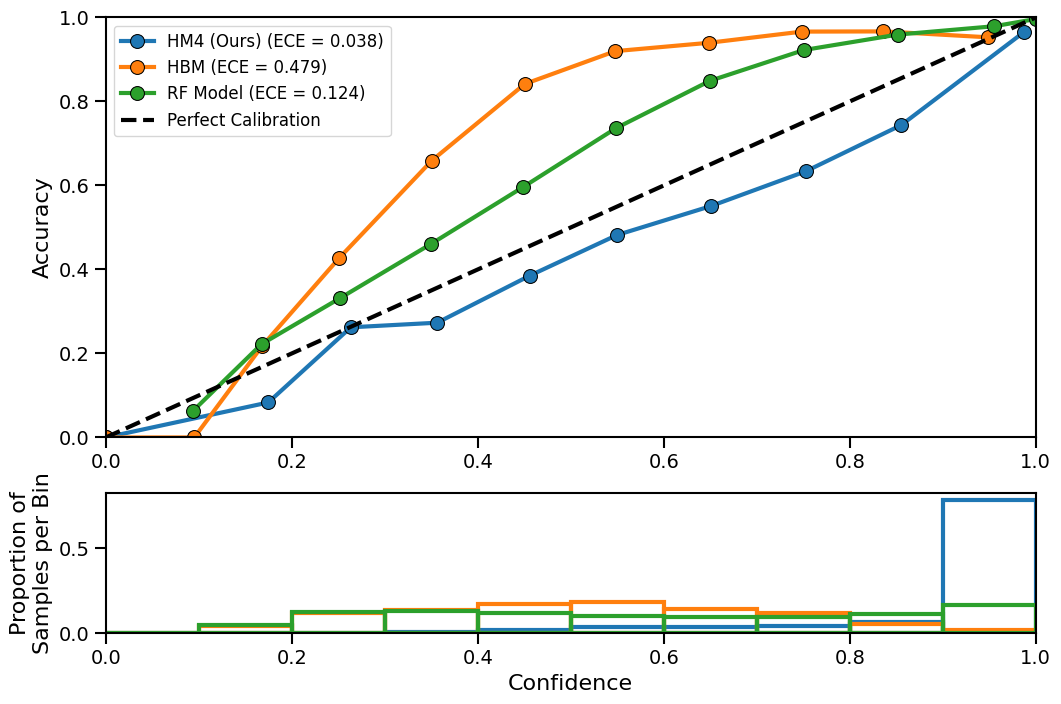

In [15]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(12, 8))

font_size = 16

sns.lineplot(
    x=hybrid_model_confidence_bins,
    y=hybrid_model_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#FC8D62",
    label="HM4 (Ours) (ECE = 0.038)",
    marker="o",
    markersize=10,
    markeredgecolor="black"
)
sns.lineplot(
    x=hbm_model_confidence_bins,
    y=hbm_model_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#891F9E",
    label="HBM (ECE = 0.479)",
    marker="o",
    markersize=10,
    markeredgecolor="black"
)
sns.lineplot(
    x=rf_model_confidence_bins,
    y=rf_model_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#891F9E",
    label="RF Model (ECE = 0.124)",
    marker="o",
    markersize=10,
    markeredgecolor="black"
)
sns.lineplot(x=[0, 1], y=[0, 1], ax=ax[0], color="k", linestyle="--", linewidth=3, label="Perfect Calibration")
ax[0].set_xlabel("", fontsize=font_size)
ax[0].set_ylabel("Accuracy", fontsize=font_size)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=font_size-4)
ax[0].tick_params(axis='both', which='major', width=1.5, length=8, labelsize=font_size-2)
ax[0].tick_params(axis='both', which='minor', width=1.5, length=8, labelsize=font_size-2)
ax[0].spines[:].set_linewidth(1.5)


sns.histplot(
    hybrid_model_conf,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#FC8D62",
    label="Proposed Model",
    fill=False,
    linewidth=3,
    stat="proportion",
)
sns.histplot(
    hbm_model_pred_probs,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#891F9E",
    label="HBM Model",
    fill=False,
    linewidth=3,
    stat="proportion",

)
sns.histplot(
    rf_model_conf,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#891F9E",
    label="RF Model",
    fill=False,
    linewidth=3,
    stat="proportion",
)
ax[1].set_xlabel("Confidence", fontsize=font_size)
ax[1].set_ylabel("Proportion of\nSamples per Bin", fontsize=font_size)
ax[1].set_xlim(0, 1)
ax[1].tick_params(axis='both', which='major', width=1.5, length=8, labelsize=font_size-2)
ax[1].tick_params(axis='both', which='minor', width=1.5, length=8, labelsize=font_size-2)
ax[1].spines[:].set_linewidth(1.5)

# plt.savefig("test_calibration_curve.png", dpi=300, bbox_inches="tight")

## Confidence Calibration - Holdout Set

In [16]:
hybrid_model_holdout_accuracy_bins = torch.load(os.path.join(DATA_DIR, "HM4_holdout_accuracy_vals.pt"))
hybrid_model_holdout_confidence_bins = torch.load(os.path.join(DATA_DIR, "HM4_holdout_confidence_vals.pt"))
hybrid_model_holdout_pred_probs = torch.load(os.path.join(DATA_DIR, "HM4_holdout_pred_probs.pt"))

In [17]:
hbm_model_holdout_accuracy_bins = torch.load(os.path.join(DATA_DIR, "HBM_holdout_accuracy_vals.pt"))
hbm_model_holdout_confidence_bins = torch.load(os.path.join(DATA_DIR, "HBM_holdout_confidence_vals.pt"))
hbm_model_holdout_pred_probs = torch.load(os.path.join(DATA_DIR, "HBM_holdout_pred_probs.pt"))

In [18]:
rf_model_holdout_accuracy_bins = torch.load(os.path.join(DATA_DIR, "dhoundiyal_holdout_accuracy_vals.pt"))
rf_model_holdout_confidence_bins = torch.load(os.path.join(DATA_DIR, "dhoundiyal_holdout_confidence_vals.pt"))
rf_model_holdout_pred_probs = torch.load(os.path.join(DATA_DIR, "dhoundiyal_holdout_pred_probs.pt"))

In [19]:
hybrid_model_holdout_conf = hybrid_model_holdout_pred_probs.max(dim=1)[0]
rf_model_holdout_conf = torch.Tensor(rf_model_holdout_pred_probs).max(dim=1)[0]

In [20]:
bin_boundaries = np.linspace(0, 1, 11)

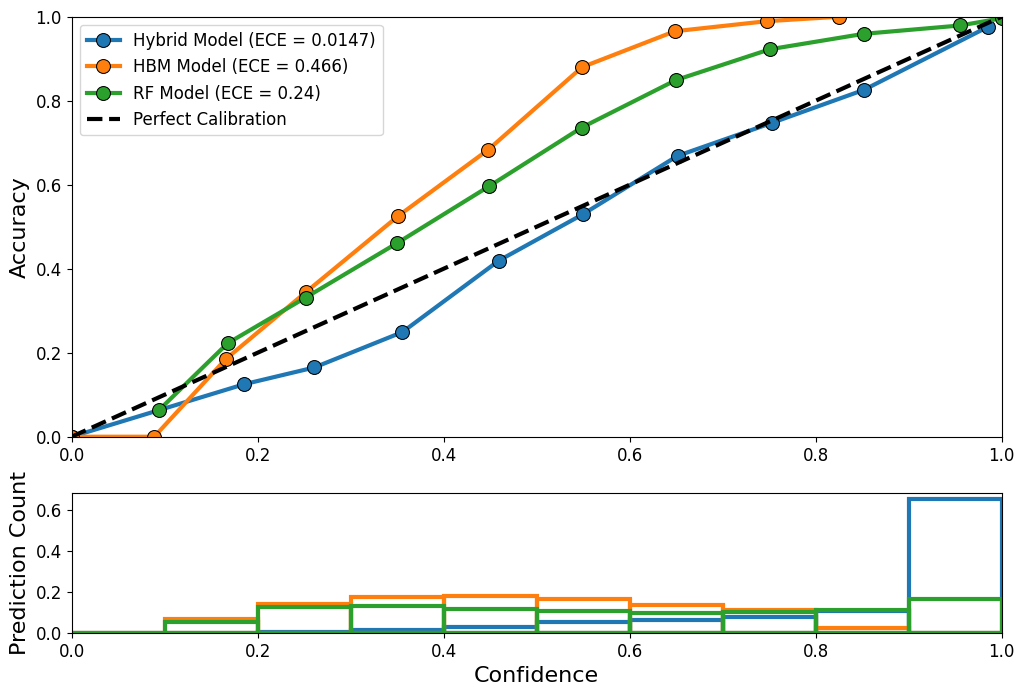

In [21]:
fig, ax = plt.subplots(2, 1, height_ratios=[3, 1], figsize=(12, 8))

font_size = 16

sns.lineplot(
    x=hybrid_model_holdout_confidence_bins,
    y=hybrid_model_holdout_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#FC8D62",
    label="Hybrid Model (ECE = 0.0147)",
    marker="o",
    markersize=10,
    markeredgecolor="black",
)
sns.lineplot(
    x=hbm_model_holdout_confidence_bins,
    y=hbm_model_holdout_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#891F9E",
    label="HBM Model (ECE = 0.466)",
    marker="o",
    markersize=10,
    markeredgecolor="black",
)
sns.lineplot(
    x=rf_model_confidence_bins,
    y=rf_model_accuracy_bins,
    ax=ax[0],
    linewidth=3,
    # color="#891F9E",
    label="RF Model (ECE = 0.240)",
    marker="o",
    markersize=10,
    markeredgecolor="black",
)
sns.lineplot(x=[0, 1], y=[0, 1], ax=ax[0], color="k", linestyle="--", linewidth=3, label="Perfect Calibration")
ax[0].set_xlabel("", fontsize=font_size)
ax[0].set_ylabel("Accuracy", fontsize=font_size)
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)
ax[0].legend(fontsize=font_size-4)
ax[0].tick_params(axis='both', which='major', labelsize=font_size-4)
ax[0].tick_params(axis='both', which='minor', labelsize=font_size-4)


sns.histplot(
    hybrid_model_holdout_conf,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#FC8D62",
    label="Proposed Model",
    fill=False,
    linewidth=3,
    stat="proportion",
)
sns.histplot(
    hbm_model_holdout_pred_probs,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#891F9E",
    label="HBM Model",
    fill=False,
    linewidth=3,
    stat="proportion",
)
sns.histplot(
    rf_model_conf,
    bins=bin_boundaries,
    ax=ax[1],
    # color="#891F9E",
    label="RF Model",
    fill=False,
    linewidth=3,
    stat="proportion",
)
ax[1].set_xlabel("Confidence", fontsize=font_size)
ax[1].set_ylabel("Prediction Count", fontsize=font_size)
ax[1].set_xlim(0, 1)
ax[1].tick_params(axis='both', which='major', labelsize=font_size-4)
ax[1].tick_params(axis='both', which='minor', labelsize=font_size-4)

# plt.savefig("holdout_calibration_curve.svg", bbox_inches="tight")